In [1]:
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.metrics import accuracy_score
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def train(model, optimizer, criterion, train_loader, test_loader, num_epochs, device):
    # Track training time
    model.to(device) 
    start_time = time.time()

    accuracy_vector = []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for x_batch, y_batch in train_loader:
            # Move both the inputs and labels to the same device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            output, _ = model(x_batch)
            loss_value = criterion(output, y_batch)
            loss_value.backward()
            optimizer.step()
            epoch_loss += loss_value.item()

        # Evaluate on the test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                # Move both the inputs and labels to the same device
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                output, _ = model(x_batch)
                _, predicted = torch.max(output, 1)  # Get predicted class
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

        accuracy = correct / total
        accuracy_vector.append(accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader)}, Accuracy: {accuracy * 100:.2f}%")

    total_time = time.time() - start_time
    print(f"Training time: {total_time:.2f} seconds")
    
    return accuracy_vector, total_time


In [4]:
def g(x):
    """Custom activation function g(x)."""
    return torch.where(x >= 0, x + 0.5, torch.sigmoid(x))

def log_g(x):
    """Log-space version of g(x) for numerical stability."""
    return torch.where(x >= 0, (F.relu(x) + 0.5).log(), -F.softplus(-x))

def parallel_scan_log(log_coeffs, log_values):
    """
    Log-space parallel scan for numerical stability.
    Args:
        log_coeffs: Tensor of shape (batch_size, seq_len, hidden_size).
        log_values: Tensor of shape (batch_size, seq_len + 1, hidden_size).
    Returns:
        Tensor of shape (batch_size, seq_len, hidden_size).
    """
    # Compute cumulative sum of log_coeffs along the sequence length dimension
    a_star = F.pad(torch.cumsum(log_coeffs, dim=1), (0, 0, 1, 0))  # Add a padding at the beginning

    # Compute cumulative sum in log-space
    log_h0_plus_b_star = torch.logcumsumexp(log_values - a_star, dim=1)
    
    # Add back a_star to compute final log_h
    log_h = a_star + log_h0_plus_b_star
    
    # Convert back from log-space and skip the initial padding
    return torch.exp(log_h)[:, 1:]

In [5]:
import json

file_path = "sarcasm.json"

with open(file_path, "r") as file:
    try:
        # Parse the entire file as a JSON array
        data = json.load(file)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        data = []

# Extract headlines and labels
headlines = [entry["headline"] for entry in data]
labels = [entry["is_sarcastic"] for entry in data]

# Tokenize headlines
def tokenize(text):
    return text.lower().split()

tokenized_headlines = [tokenize(headline) for headline in headlines]

# Build vocabulary
word_counts = Counter(word for headline in tokenized_headlines for word in headline)
vocab = {word: i+1 for i, (word, _) in enumerate(word_counts.most_common())}  # +1 for padding
vocab_size = len(vocab) + 1  # Extra for padding

# Encode headlines and labels
max_length = 20  # Truncate/pad to this length
encoded_headlines = [
    [vocab.get(word, 0) for word in headline[:max_length]] + [0] * (max_length - len(headline))
    for headline in tokenized_headlines
]

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(encoded_headlines, encoded_labels, test_size=0.8, random_state=42)


In [6]:
class SarcasmDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Create datasets and data loaders
batch_size = 64

train_dataset = SarcasmDataset(X_train, y_train)
test_dataset = SarcasmDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# GRU, NN

In [7]:
import torch
import torch.nn as nn

class NNGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(NNGRU, self).__init__()
        
        # Define layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)  # GRU layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden=None):
        # Embed input
        x = self.embedding(x)

        # Apply GRU
        out, hidden = self.gru(x, hidden)

        # Use the final hidden state for classification
        out = self.fc(out[:, -1, :])  # Use the last time step output
        return out, hidden

# Model parameters
embedding_dim = 100
hidden_dim = 128
output_dim = len(label_encoder.classes_)

model_nn_gru = NNGRU(vocab_size, embedding_dim, hidden_dim, output_dim)

In [8]:
criterion_gru = nn.CrossEntropyLoss()
optimizer_gru = optim.Adam(model_nn_gru.parameters(), lr=0.001)

# GRU Handmade

In [9]:
import torch
import torch.nn as nn


class HandmadeGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(HandmadeGRUCell, self).__init__()
        self.hidden_size = hidden_size

        # Update gate (z), Reset gate (r), Candidate hidden state (h_tilde)
        self.W_z = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_r = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_h = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, input, hidden):
        # Concatenate previous hidden state and current input
        combined = torch.cat((hidden, input), dim=1)

        # Compute gates and candidate hidden state
        z = torch.sigmoid(self.W_z(combined))  # Update gate
        r = torch.sigmoid(self.W_r(combined))  # Reset gate

        # Compute candidate hidden state
        combined_reset = torch.cat((r * hidden, input), dim=1)
        h_tilde = torch.tanh(self.W_h(combined_reset))

        # Compute new hidden state
        h_new = (1 - z) * hidden + z * h_tilde

        return h_new

class GRUHM(nn.Module):
    def __init__(self, units, embedding_size, vocab_size, input_length):
        super(GRUHM, self).__init__()
        self.input_length = input_length
        self.units = units

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.gru_cell = HandmadeGRUCell(embedding_size, units)
        self.classification_model = nn.Sequential(
            nn.Linear(units, 64),
            nn.Linear(64, 2),  # Output layer for binary classification (0, 1)
            nn.Sigmoid()
        )

    def forward(self, sentence):
        batch_size = sentence.shape[0]

        # Initialize the hidden state (h)
        h = torch.zeros(batch_size, self.units, device=sentence.device)

        # Pass the sentence through the embedding layer to get word embeddings
        embedded_sentence = self.embedding(sentence)

        # Iterate over each word in the sentence
        for i in range(embedded_sentence.shape[1]):
            word = embedded_sentence[:, i, :]
            h = self.gru_cell(word, h)  # Update h using the GRU cell

        # Pass the final hidden state through the classification model
        return self.classification_model(h), None  # Predict the class
    
model_nn_gru_hm = GRUHM(units=hidden_dim, embedding_size=embedding_dim, vocab_size=vocab_size, input_length=100)


In [10]:
criterion_gru_hm = nn.CrossEntropyLoss()
optimizer_gru_hm = optim.Adam(model_nn_gru_hm.parameters(), lr=0.001)

# MinGRU

In [11]:
import torch
import torch.nn as nn

class MinGRUCell(nn.Module):
    def __init__(self, units, input_shape):
        super(MinGRUCell, self).__init__()
        self.units = units
        self.input_shape = input_shape
        
        # Initialize the linear layers for the forget gate, input gate, and hidden state transformation
        self.linear_f = nn.Linear(self.input_shape, self.units)
        self.linear_i = nn.Linear(self.input_shape, self.units)
        self.linear_h = nn.Linear(self.input_shape, self.units)

    def forward(self, x_t, h_prev):
        # x_t: (batch_size, 1, input_size)
        # h_prev: (batch_size, 1, hidden_size)
        f_t = torch.sigmoid(self.linear_f(x_t))
        i_t = torch.sigmoid(self.linear_i(x_t))
        tilde_h_t = g(self.linear_h(x_t))
        f_prime_t = f_t / (f_t + i_t)
        i_prime_t = i_t / (f_t + i_t)
        h_t = f_prime_t * h_prev + i_prime_t * tilde_h_t
        return h_t
    

class MinRNNGRU(nn.Module):
    def __init__(self, units, embedding_size, vocab_size, input_length):
        super(MinRNNGRU, self).__init__()
        self.input_length = input_length
        self.units = units

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.gru = MinGRUCell(units, embedding_size)
        self.classification_model = nn.Sequential(
            nn.Linear(units, 64),
            nn.Linear(64, 2),
            nn.Sigmoid()
        )

    def forward(self, sentence):
        """
        Args:
            sentence: (batch_size, input_length)

        output:
            (batch_size, 1)

        """
        
        batch_size = sentence.shape[0]

        # Initialize the hidden state, only the h needs to be initialized
        pre_h = torch.zeros(batch_size, self.units, device=sentence.device)

        # Pass the sentence through the embedding layer for the word vectors embeddings
        embedded_sentence = self.embedding(sentence)

        sequence_length = embedded_sentence.shape[1]

        # Pass the entire sequence through the LSTM + hidden_state
        for i in range(sequence_length):
            word = embedded_sentence[:, i, :]  # (batch_size, embedding_size)
            pre_h = self.gru(word,pre_h )  # Only update h (hidden state)

        return self.classification_model(pre_h),None  # Pass the final hidden state into the classification network
    
# Model parameters
embedding_dim = 100
hidden_dim = 128
output_dim = len(label_encoder.classes_)


model_nn_gru_mini = MinRNNGRU(units=hidden_dim, embedding_size=embedding_dim, vocab_size=vocab_size, input_length=100)

In [12]:
criterion_gru_mini = nn.CrossEntropyLoss()
optimizer_gru_mini = optim.Adam(model_nn_gru_mini.parameters(), lr=0.001)

# MinGruSeq

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class MinGRUCellSeq(nn.Module):
    def __init__(self, units, input_shape):
        """
        A log-space version of a minimal LSTM cell for improved numerical stability.
        Args:
            units: Number of hidden units.
            input_shape: Input dimensionality.
        """
        super(MinGRUCellSeq, self).__init__()
        self.units = units
        self.input_shape = input_shape

        # Linear layers for LSTM gates
        self.linear_z = nn.Linear(self.input_shape, self.units)  # Forget gate
        self.linear_h = nn.Linear(self.input_shape, self.units)  # Candidate hidden state

    def forward(self, x, h_0):
        # x: (batch_size, seq_len, input_size)
        # h_0: (batch_size, 1, hidden_size)
        k = self.linear_z(x)
        log_z =-F.softplus(-k)
        log_coeffs =-F.softplus(k)

        log_h_0 = log_g(h_0)
        log_tilde_h = log_g(self.linear_h(x))
        log_tilde_h = log_g(self.linear_h(x))
        h = parallel_scan_log(log_coeffs,torch.cat([log_h_0, log_z + log_tilde_h], dim=1))
        return h

class MinGRURNNSeq(nn.Module):
    def __init__(self, units, embedding_size, vocab_size, input_length):
        """
        Minimal RNN model with log-space LSTM for numerical stability.
        Args:
            units: Number of hidden units.
            embedding_size: Dimensionality of word embeddings.
            vocab_size: Vocabulary size for embedding layer.
            input_length: Sequence length.
        """
        super(MinGRURNNSeq, self).__init__()
        self.input_length = input_length
        self.units = units

        # Embedding layer for input sentences
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        self.gru = MinGRUCellSeq(units, embedding_size)

        # Fully connected layers for classification
        self.classification_model = nn.Sequential(
            nn.Linear(units, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
            nn.Sigmoid()
        )

    def forward(self, sentence):
        """
        Forward pass for the RNN model.
        Args:
            sentence: Tensor of shape (batch_size, seq_len) containing tokenized sentences.
        Returns:
            Classification output of shape (batch_size, num_classes).
        """
        batch_size = sentence.shape[0]

        # Initialize hidden state (h_0) with zeros
        pre_h = torch.zeros(batch_size, 1, self.units, device=sentence.device)

        # Pass sentence through embedding layer
        embedded_sentence = self.embedding(sentence)  # Shape: (batch_size, seq_len, embedding_size)

        # Pass embedded input and initial hidden state through LSTM cell
        h = self.gru(embedded_sentence, pre_h)  # Shape: (batch_size, seq_len, units)

        # Use the last hidden state for classification
        final_hidden_state = h[:, -1, :]  # Shape: (batch_size, units)

        # Pass through classification model
        output = self.classification_model(final_hidden_state)

        return output,None

# Model parameters
embedding_dim = 100
hidden_dim = 128
output_dim = len(label_encoder.classes_)


model_nn_gru_mini_seq = MinGRURNNSeq(units=hidden_dim, embedding_size=embedding_dim, vocab_size=vocab_size, input_length=100)

In [36]:
criterion_gru_mini_seq = nn.CrossEntropyLoss()
optimizer_gru_mini_seq = optim.Adam(model_nn_gru_mini_seq.parameters(), lr=0.001)

# LSTM

In [15]:
import torch
import torch.nn as nn

class NNLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(NNLSTM, self).__init__()
        
        # Define layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)  # LSTM layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden=None):
        # Embed input
        x = self.embedding(x)

        # Apply LSTM
        out, (hidden, cell) = self.lstm(x, hidden)

        # Use the final hidden state for classification
        out = self.fc(out[:, -1, :])  # Use the last time step output
        return out, hidden

# Model parameters
embedding_dim = 100
hidden_dim = 128
output_dim = len(label_encoder.classes_)

model_nn_lstm = NNLSTM(vocab_size, embedding_dim, hidden_dim, output_dim)


In [16]:
criterion_lstm = nn.CrossEntropyLoss()
optimizer_lstm = optim.Adam(model_nn_lstm.parameters(), lr=0.001)


# LSTM, handmade

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HandmadeLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(HandmadeLSTMCell, self).__init__()
        self.hidden_size = hidden_size
        
        # Forget gate (f), Input gate (i), Output gate (o), Candidate cell state (g)
        self.W_f = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_i = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_o = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_g = nn.Linear(input_size + hidden_size, hidden_size)
    
    def forward(self, input, hidden):
        h, c = hidden
        
        # Concatenate previous hidden state and current input
        combined = torch.cat((h, input), 1)
        
        # Forget gate (f), Input gate (i), Output gate (o), Candidate cell state (g)
        f = torch.sigmoid(self.W_f(combined))
        i = torch.sigmoid(self.W_i(combined))
        o = torch.sigmoid(self.W_o(combined))
        g = torch.tanh(self.W_g(combined))
        
        # Cell state update
        c_new = f * c + i * g
        
        # Hidden state update
        h_new = o * torch.tanh(c_new)
        
        return h_new, c_new

In [42]:
class LSTMHM(nn.Module):
    def __init__(self, units, embedding_size, vocab_size, input_length):
        super(LSTMHM, self).__init__()
        self.input_length = input_length
        self.units = units

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm_cell = HandmadeLSTMCell(embedding_size, units)
        self.classification_model = nn.Sequential(
            nn.Linear(units, 64),
            nn.Linear(64, 2),  # Output layer for binary classification (0, 1)
            nn.Sigmoid()
        )

    def forward(self, sentence):
        batch_size = sentence.shape[0]

        # Initialize the hidden state (h) and cell state (c)
        h = torch.zeros(batch_size, self.units, device=sentence.device)
        c = torch.zeros(batch_size, self.units, device=sentence.device)

        # Pass the sentence through the embedding layer to get word embeddings
        embedded_sentence = self.embedding(sentence)

        # Iterate over each word in the sentence
        for i in range(embedded_sentence.shape[1]):
            word = embedded_sentence[:, i, :]
            h, c = self.lstm_cell(word, (h, c))  # Update h and c using the LSTM cell

        # Pass the final hidden state through the classification model
        return self.classification_model(h), None  # Predict the class

# Model parameters
embedding_dim = 100
hidden_dim = 128
output_dim = len(label_encoder.classes_)


model_nn_lstm_hm = LSTMHM(units=hidden_dim, embedding_size=embedding_dim, vocab_size=vocab_size, input_length=100)

In [43]:
criterion_lstm_hm = nn.CrossEntropyLoss()
optimizer_lstm_hm = optim.Adam(model_nn_lstm_hm.parameters(), lr=0.001)

# MINILSTM

In [20]:
import torch
import torch.nn as nn

class MinLSTMCell(nn.Module):
    def __init__(self, units, input_shape):
        super(MinLSTMCell, self).__init__()
        self.units = units
        self.input_shape = input_shape
        
        # Initialize the linear layers for the forget gate, input gate, and hidden state transformation
        self.linear_f = nn.Linear(self.input_shape, self.units)
        self.linear_i = nn.Linear(self.input_shape, self.units)
        self.linear_h = nn.Linear(self.input_shape, self.units)

    def forward(self, pre_h, x_t):
        """
        pre_h: (batch_size, units) - previous hidden state (h_prev)
        x_t: (batch_size, input_size) - input at time step t
        """

        # Forget gate: f_t = sigmoid(W_f * x_t)
        f_t = torch.sigmoid(self.linear_f(x_t))  # (batch_size, units)

        # Input gate: i_t = sigmoid(W_i * x_t)
        i_t = torch.sigmoid(self.linear_i(x_t))  # (batch_size, units)

        # Hidden state: tilde_h_t = W_h * x_t
        tilde_h_t = self.linear_h(x_t)  # (batch_size, units)

        # Normalize the gates
        sum_f_i = f_t + i_t
        f_prime_t = f_t / sum_f_i  # (batch_size, units)
        i_prime_t = i_t / sum_f_i  # (batch_size, units)

        # New hidden state: h_t = f_prime_t * pre_h + i_prime_t * tilde_h_t
        h_t = f_prime_t * pre_h + i_prime_t * tilde_h_t  # (batch_size, units)

        return h_t  # (batch_size, units)

In [21]:
class MinRNN(nn.Module):
    def __init__(self, units, embedding_size, vocab_size, input_length):
        super(MinRNN, self).__init__()
        self.input_length = input_length
        self.units = units

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = MinLSTMCell(units, embedding_size)
        self.classification_model = nn.Sequential(
            nn.Linear(units, 64),
            nn.Linear(64, 2),
            nn.Sigmoid()
        )

    def forward(self, sentence):
        """
        Args:
            sentence: (batch_size, input_length)

        output:
            (batch_size, 1)

        """
        
        batch_size = sentence.shape[0]

        # Initialize the hidden state, only the h needs to be initialized
        pre_h = torch.zeros(batch_size, self.units, device=sentence.device)

        # Pass the sentence through the embedding layer for the word vectors embeddings
        embedded_sentence = self.embedding(sentence)

        sequence_length = embedded_sentence.shape[1]

        # Pass the entire sequence through the LSTM + hidden_state
        for i in range(sequence_length):
            word = embedded_sentence[:, i, :]  # (batch_size, embedding_size)
            pre_h = self.lstm(pre_h, word)  # Only update h (hidden state)

        return self.classification_model(pre_h),None  # Pass the final hidden state into the classification network
    
# Model parameters
embedding_dim = 100
hidden_dim = 128
output_dim = len(label_encoder.classes_)


model_nn_lstm_mini = MinRNN(units=hidden_dim, embedding_size=embedding_dim, vocab_size=vocab_size, input_length=100)

In [22]:
criterion_lstm_mini = nn.CrossEntropyLoss()
optimizer_lstm_mini = optim.Adam(model_nn_lstm_mini.parameters(), lr=0.001)

# Seq minLSTM

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class MinLSTMCellSeq(nn.Module):
    def __init__(self, units, input_shape):
        """
        A log-space version of a minimal LSTM cell for improved numerical stability.
        Args:
            units: Number of hidden units.
            input_shape: Input dimensionality.
        """
        super(MinLSTMCellSeq, self).__init__()
        self.units = units
        self.input_shape = input_shape

        # Linear layers for LSTM gates
        self.linear_f = nn.Linear(self.input_shape, self.units)  # Forget gate
        self.linear_i = nn.Linear(self.input_shape, self.units)  # Input gate
        self.linear_h = nn.Linear(self.input_shape, self.units)  # Candidate hidden state

    def forward(self, x, h_0):
        """
        Forward pass of the LSTM cell in log-space.
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_size).
            h_0: Initial hidden state of shape (batch_size, 1, hidden_size).
        Returns:
            Updated hidden states of shape (batch_size, seq_len, hidden_size).
        """
        # Compute diff, log_f, and log_i for log-space operations
        diff = F.softplus(-self.linear_f(x)) - F.softplus(-self.linear_i(x))
        log_f = -F.softplus(diff)
        log_i = -F.softplus(-diff)
        
        # Log-space transformation of h_0 and candidate hidden state
        log_h_0 = torch.log(h_0)
        log_tilde_h = log_g(self.linear_h(x))

        # Concatenate log_h_0 with transformed input to process through parallel_scan_log
        h = parallel_scan_log(log_f, torch.cat([log_h_0, log_i + log_tilde_h], dim=1))

        return h

class MinRNNSeq(nn.Module):
    def __init__(self, units, embedding_size, vocab_size, input_length):
        """
        Minimal RNN model with log-space LSTM for numerical stability.
        Args:
            units: Number of hidden units.
            embedding_size: Dimensionality of word embeddings.
            vocab_size: Vocabulary size for embedding layer.
            input_length: Sequence length.
        """
        super(MinRNNSeq, self).__init__()
        self.input_length = input_length
        self.units = units

        # Embedding layer for input sentences
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # LSTM Cell
        self.lstm = MinLSTMCellSeq(units, embedding_size)

        # Fully connected layers for classification
        self.classification_model = nn.Sequential(
            nn.Linear(units, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
            nn.Sigmoid()
        )

    def forward(self, sentence):
        """
        Forward pass for the RNN model.
        Args:
            sentence: Tensor of shape (batch_size, seq_len) containing tokenized sentences.
        Returns:
            Classification output of shape (batch_size, num_classes).
        """
        batch_size = sentence.shape[0]

        # Initialize hidden state (h_0) with zeros
        pre_h = torch.zeros(batch_size, 1, self.units, device=sentence.device)

        # Pass sentence through embedding layer
        embedded_sentence = self.embedding(sentence)  # Shape: (batch_size, seq_len, embedding_size)

        # Pass embedded input and initial hidden state through LSTM cell
        h = self.lstm(embedded_sentence, pre_h)  # Shape: (batch_size, seq_len, units)

        # Use the last hidden state for classification
        final_hidden_state = h[:, -1, :]  # Shape: (batch_size, units)

        # Pass through classification model
        output = self.classification_model(final_hidden_state)

        return output,None

# Model parameters
embedding_dim = 100
hidden_dim = 128
output_dim = len(label_encoder.classes_)


model_nn_lstm_mini_seq = MinRNNSeq(units=hidden_dim, embedding_size=embedding_dim, vocab_size=vocab_size, input_length=100)

In [24]:
criterion_lstm_mini_seq = nn.CrossEntropyLoss()
optimizer_lstm_mini_seq = optim.Adam(model_nn_lstm_mini_seq.parameters(), lr=0.001)

# END

In [25]:
num_epoch = 10

In [26]:
def train_mini(model, criterion, optimizer, device, num_epoch, train_loader, test_loader):

    # Track training time
    start_time = time.time()
    
    # List to store accuracy values for each epoch
    accuracy_vector = []
    model_nn_lstm_mini.to(device)
    for epoch in range(num_epoch):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch in train_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            
            
            optimizer.zero_grad()
            outputs,_ = model(inputs)
            
            loss = criterion( outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            prediction = torch.argmax(outputs, dim=1)
            # Ensure labels are of shape [batch_size]
            correct += (prediction == labels.float()).sum().item()
            total += labels.size(0)

        # Evaluate on the test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device) 
                output, _ = model(x_batch)
                _, predicted = torch.max(output, 1)  # Get predicted class
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

        # Compute accuracy for this epoch
        accuracy = correct / total
        accuracy_vector.append(accuracy)
        
        print(f"Epoch {epoch+1}/{num_epoch}, Loss: {total_loss/len(train_loader)}, Accuracy: {accuracy * 100:.2f}%")

    # Track total training time
    total_time = time.time() - start_time
    print(f"Training time: {total_time:.2f} seconds")
    
    return accuracy_vector,total_time




In [27]:
model_nn_lstm_mini.to(device)
print("oui : ? : " , torch.cuda.is_available())
accuracy_lstm_mini, time_lstm_mini = train_mini(model_nn_lstm_mini, criterion_lstm_mini, optimizer_lstm_mini, device, num_epoch,  train_loader, test_loader)

oui : ? :  True
Epoch 1/10, Loss: 0.6872312327226003, Accuracy: 56.36%
Epoch 2/10, Loss: 0.6740422610725675, Accuracy: 59.51%
Epoch 3/10, Loss: 0.6126188635826111, Accuracy: 63.61%
Epoch 4/10, Loss: 0.5472227061788241, Accuracy: 65.59%
Epoch 5/10, Loss: 0.49471068737052737, Accuracy: 66.59%
Epoch 6/10, Loss: 0.45386705689487006, Accuracy: 66.70%
Epoch 7/10, Loss: 0.42385989675919217, Accuracy: 67.27%
Epoch 8/10, Loss: 0.4050338129912104, Accuracy: 67.25%
Epoch 9/10, Loss: 0.3935774305746669, Accuracy: 67.40%
Epoch 10/10, Loss: 0.38590541623887564, Accuracy: 67.51%
Training time: 69.94 seconds


In [28]:
model_nn_gru_mini.to(device)
print("oui : ? : " , torch.cuda.is_available())
accuracy_gru_mini, time_gru_mini = train_mini(model_nn_gru_mini, criterion_gru_mini, optimizer_gru_mini, device, num_epoch,  train_loader, test_loader)

oui : ? :  True
Epoch 1/10, Loss: 0.6875146180391312, Accuracy: 56.18%
Epoch 2/10, Loss: 0.682054938304992, Accuracy: 58.29%
Epoch 3/10, Loss: 0.6350134710470835, Accuracy: 62.30%
Epoch 4/10, Loss: 0.5602492243051529, Accuracy: 65.20%
Epoch 5/10, Loss: 0.5040538782874743, Accuracy: 66.80%
Epoch 6/10, Loss: 0.46109060446421307, Accuracy: 67.48%
Epoch 7/10, Loss: 0.42788647824809667, Accuracy: 67.97%
Epoch 8/10, Loss: 0.4045946076512337, Accuracy: 67.88%
Epoch 9/10, Loss: 0.38896202473413377, Accuracy: 68.13%
Epoch 10/10, Loss: 0.3785934920112292, Accuracy: 68.03%
Training time: 85.28 seconds


In [29]:
accuracy_gru, time_gru = train(model_nn_gru, optimizer_gru, criterion_gru, train_loader, test_loader, num_epoch, device)

Epoch 1/10, Loss: 0.6898946584690184, Accuracy: 58.66%
Epoch 2/10, Loss: 0.5553478204778263, Accuracy: 73.83%
Epoch 3/10, Loss: 0.39537965861104785, Accuracy: 75.69%
Epoch 4/10, Loss: 0.2627413735858032, Accuracy: 77.48%
Epoch 5/10, Loss: 0.15988626184740237, Accuracy: 77.15%
Epoch 6/10, Loss: 0.08995342950913168, Accuracy: 76.85%
Epoch 7/10, Loss: 0.041720524890392664, Accuracy: 77.48%
Epoch 8/10, Loss: 0.029623009089846164, Accuracy: 76.24%
Epoch 9/10, Loss: 0.016081965540901626, Accuracy: 76.61%
Epoch 10/10, Loss: 0.01955830797600183, Accuracy: 76.96%
Training time: 7.89 seconds


In [30]:
accuracy_lstm, time_lstm = train(model_nn_lstm, optimizer_lstm, criterion_lstm, train_loader, test_loader, num_epoch, device)

Epoch 1/10, Loss: 0.686901657354264, Accuracy: 56.33%
Epoch 2/10, Loss: 0.6586588741767974, Accuracy: 69.07%
Epoch 3/10, Loss: 0.4948520390760331, Accuracy: 73.59%
Epoch 4/10, Loss: 0.36337413851703915, Accuracy: 75.36%
Epoch 5/10, Loss: 0.24356608234700702, Accuracy: 76.25%
Epoch 6/10, Loss: 0.13954689794973957, Accuracy: 76.50%
Epoch 7/10, Loss: 0.08680437518549818, Accuracy: 76.98%
Epoch 8/10, Loss: 0.06270947929338686, Accuracy: 77.35%
Epoch 9/10, Loss: 0.03280339750372583, Accuracy: 76.06%
Epoch 10/10, Loss: 0.02685461675199414, Accuracy: 75.83%
Training time: 8.37 seconds


In [44]:
accuracy_lstm_hm, time_lstm_hm = train(model_nn_lstm_hm, optimizer_lstm_hm, criterion_lstm_hm, train_loader, test_loader, num_epoch, device)

Epoch 1/10, Loss: 0.6878280852522168, Accuracy: 56.31%
Epoch 2/10, Loss: 0.6700236527692705, Accuracy: 61.00%
Epoch 3/10, Loss: 0.6429888237090338, Accuracy: 61.81%
Epoch 4/10, Loss: 0.6326116543440592, Accuracy: 63.81%
Epoch 5/10, Loss: 0.6043446624562854, Accuracy: 65.65%
Epoch 6/10, Loss: 0.5699014823351588, Accuracy: 68.19%
Epoch 7/10, Loss: 0.5416448751375789, Accuracy: 68.59%
Epoch 8/10, Loss: 0.523720336102304, Accuracy: 69.13%
Epoch 9/10, Loss: 0.505841080276739, Accuracy: 69.81%
Epoch 10/10, Loss: 0.5098554889361063, Accuracy: 69.93%
Training time: 83.40 seconds


In [31]:
accuracy_gru_hm, time_gru_hm = train(model_nn_gru_hm, optimizer_gru_hm, criterion_gru_hm, train_loader, test_loader, num_epoch, device)

Epoch 1/10, Loss: 0.6867139488458633, Accuracy: 56.35%
Epoch 2/10, Loss: 0.6051468778224218, Accuracy: 71.33%
Epoch 3/10, Loss: 0.5167972959932827, Accuracy: 74.64%
Epoch 4/10, Loss: 0.4641334900543803, Accuracy: 74.83%
Epoch 5/10, Loss: 0.4329079322162129, Accuracy: 75.07%
Epoch 6/10, Loss: 0.41081189222279046, Accuracy: 75.96%
Epoch 7/10, Loss: 0.39264278752463205, Accuracy: 75.30%
Epoch 8/10, Loss: 0.3845340410868327, Accuracy: 76.39%
Epoch 9/10, Loss: 0.3811095076657477, Accuracy: 75.85%
Epoch 10/10, Loss: 0.3775492243113972, Accuracy: 75.58%
Training time: 70.06 seconds


In [32]:
def train_mini_seq(model, criterion, optimizer, device, num_epoch, train_loader, test_loader):
    # Track training time
    start_time = time.time()
    
    # List to store accuracy values for each epoch
    accuracy_vector = []

    for epoch in range(num_epoch):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch in train_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, _ = model(inputs)  # The model processes the entire batch

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            prediction = torch.argmax(outputs, dim=1)
            correct += (prediction == labels).sum().item()
            total += labels.size(0)

        # Evaluate on the test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move to device
                output, _ = model(x_batch)  # The model processes the entire batch
                predicted = torch.argmax(output, dim=1)  # Get predicted class
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

        # Compute accuracy for this epoch
        accuracy = correct / total
        accuracy_vector.append(accuracy)
        
        print(f"Epoch {epoch+1}/{num_epoch}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {accuracy * 100:.2f}%")

    # Track total training time
    total_time = time.time() - start_time
    print(f"Training time: {total_time:.2f} seconds")
    
    return accuracy_vector, total_time



In [33]:

model_nn_lstm_mini_seq.to(device)
print("oui : ? : " , torch.cuda.is_available())
accuracy_lstm_mini_seq, time_lstm_mini_se = train_mini_seq(model_nn_lstm_mini_seq, criterion_lstm_mini_seq, optimizer_lstm_mini_seq, device, num_epoch,  train_loader, test_loader)

oui : ? :  True
Epoch 1/10, Loss: 0.6879, Accuracy: 56.18%
Epoch 2/10, Loss: 0.6857, Accuracy: 56.24%
Epoch 3/10, Loss: 0.6631, Accuracy: 61.62%
Epoch 4/10, Loss: 0.5763, Accuracy: 65.42%
Epoch 5/10, Loss: 0.5050, Accuracy: 67.13%
Epoch 6/10, Loss: 0.4593, Accuracy: 67.51%
Epoch 7/10, Loss: 0.4273, Accuracy: 68.50%
Epoch 8/10, Loss: 0.4014, Accuracy: 68.56%
Epoch 9/10, Loss: 0.3827, Accuracy: 68.78%
Epoch 10/10, Loss: 0.3716, Accuracy: 68.69%
Training time: 14.00 seconds


In [37]:

model_nn_gru_mini_seq.to(device)
print("oui : ? : " , torch.cuda.is_available())
accuracy_gru_mini_seq, time_gru_mini_se = train_mini_seq(model_nn_gru_mini_seq, criterion_gru_mini_seq, optimizer_gru_mini_seq, device, num_epoch,  train_loader, test_loader)

oui : ? :  True
Epoch 1/10, Loss: 0.6865, Accuracy: 56.40%
Epoch 2/10, Loss: 0.6833, Accuracy: 57.31%
Epoch 3/10, Loss: 0.6452, Accuracy: 62.52%
Epoch 4/10, Loss: 0.5660, Accuracy: 64.85%
Epoch 5/10, Loss: 0.5068, Accuracy: 66.46%
Epoch 6/10, Loss: 0.4606, Accuracy: 66.96%
Epoch 7/10, Loss: 0.4274, Accuracy: 67.20%
Epoch 8/10, Loss: 0.4031, Accuracy: 67.59%
Epoch 9/10, Loss: 0.3880, Accuracy: 67.54%
Epoch 10/10, Loss: 0.3791, Accuracy: 67.71%
Training time: 14.32 seconds


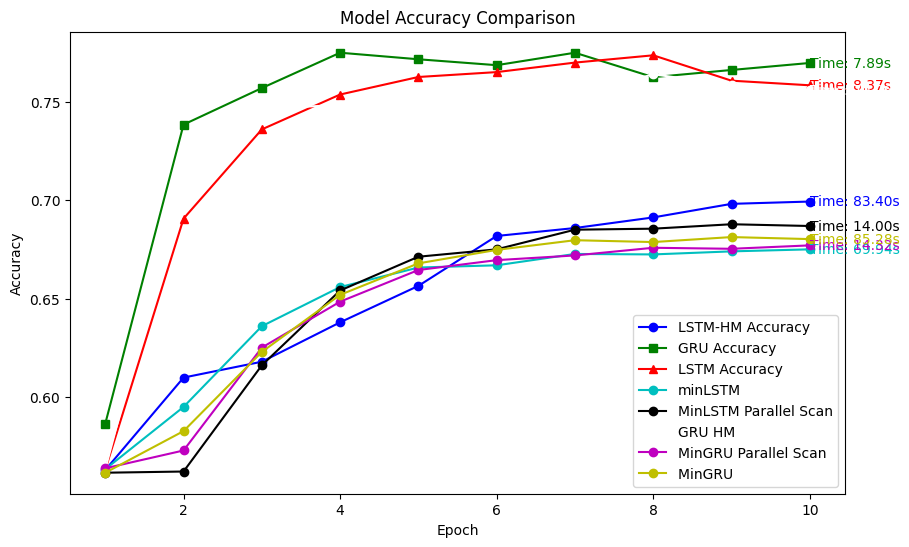

In [47]:
import matplotlib.pyplot as plt

# Assuming you have accuracy and time for each model
# Example: accuracy_lstm_hm, accuracy_gru, accuracy_lstm
# Example: time_lstm_hm, time_gru, time_lstm

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracy_lstm_hm) + 1), accuracy_lstm_hm, marker='o', color='b', label='LSTM-HM Accuracy')
plt.plot(range(1, len(accuracy_gru) + 1), accuracy_gru, marker='s', color='g', label='GRU Accuracy')
plt.plot(range(1, len(accuracy_lstm) + 1), accuracy_lstm, marker='^', color='r', label='LSTM Accuracy')
plt.plot(range(1, len(accuracy_lstm_mini) + 1), accuracy_lstm_mini, marker='o', color='c', label='minLSTM')
plt.plot(range(1, len(accuracy_lstm_mini_seq) + 1), accuracy_lstm_mini_seq, marker='o', color='k', label='MinLSTM Parallel Scan')

plt.plot(range(1, len(accuracy_gru_hm) + 1), accuracy_gru_hm, marker='o', color='w', label='GRU HM')
plt.plot(range(1, len(accuracy_gru_mini_seq) + 1), accuracy_gru_mini_seq, marker='o', color='m', label='MinGRU Parallel Scan')
plt.plot(range(1, len(accuracy_gru_mini) + 1), accuracy_gru_mini, marker='o', color='y', label='MinGRU ')

# Adding labels and title for accuracy
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

# Displaying global training time at the end of each curve
plt.text(len(accuracy_lstm_hm), accuracy_lstm_hm[-1], f'Time: {time_lstm_hm:.2f}s', color='b', ha='left', va='center')
plt.text(len(accuracy_gru), accuracy_gru[-1], f'Time: {time_gru:.2f}s', color='g', ha='left', va='center')
plt.text(len(accuracy_lstm), accuracy_lstm[-1], f'Time: {time_lstm:.2f}s', color='r', ha='left', va='center')
plt.text(len(accuracy_lstm_mini), accuracy_lstm_mini[-1], f'Time: {time_lstm_mini:.2f}s', color='c', ha='left', va='center')
plt.text(len(accuracy_lstm_mini_seq), accuracy_lstm_mini_seq[-1], f'Time: {time_lstm_mini_se:.2f}s', color='k', ha='left', va='center')

plt.text(len(accuracy_gru_hm), accuracy_gru_hm[-1], f'Time: {time_gru_hm:.2f}s', color='w', ha='left', va='center')
plt.text(len(accuracy_gru_mini_seq), accuracy_gru_mini_seq[-1], f'Time: {time_gru_mini_se:.2f}s', color='m', ha='left', va='center')
plt.text(len(accuracy_gru_mini), accuracy_gru_mini[-1], f'Time: {time_gru_mini:.2f}s', color='y', ha='left', va='center')


plt.legend()

# Save the plot to a file
plt.savefig('model_accuracy_comparison.png')  # You can change the filename and path if needed

# Display the plot
plt.show()


In [49]:
def test_accuracy(model, test_loader):
    start_time = time.time()
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move to device
            output, _ = model(x_batch)  # The model processes the entire batch
            predicted = torch.argmax(output, dim=1)  # Get predicted class
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    total_time = time.time() - start_time
    print(f"Computing time: {total_time:.2f} seconds")
    return total_time  # Return as a float (no formatting here)


In [50]:
a = test_accuracy(model_nn_lstm_hm,test_loader)
b = test_accuracy(model_nn_lstm_mini,test_loader)
c = test_accuracy(model_nn_lstm_mini_seq,test_loader)

d = test_accuracy(model_nn_gru_hm,test_loader)
e = test_accuracy(model_nn_gru_mini,test_loader)
f = test_accuracy(model_nn_gru_mini_seq,test_loader)

Computing time: 3.76 seconds
Computing time: 3.25 seconds
Computing time: 0.92 seconds
Computing time: 3.49 seconds
Computing time: 4.33 seconds
Computing time: 0.82 seconds


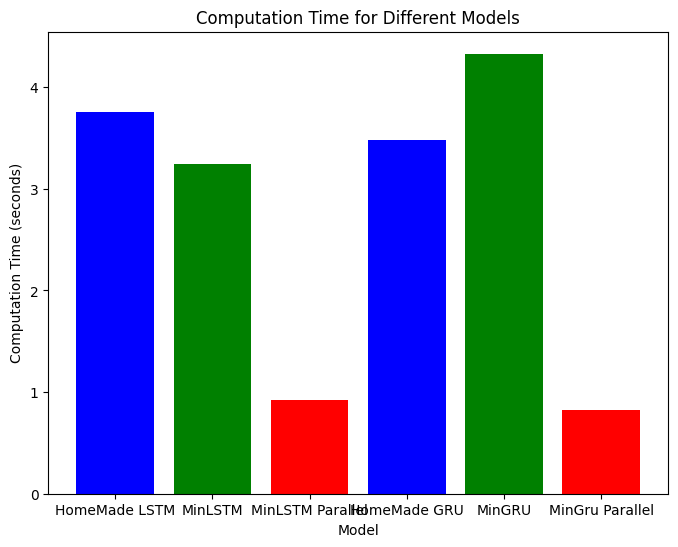

In [52]:
import matplotlib.pyplot as plt

model_names = ['HomeMade LSTM', 'MinLSTM', 'MinLSTM Parallel', 'HomeMade GRU', 'MinGRU', 'MinGru Parallel']
times = [a, b, c,d,e,f]  

plt.figure(figsize=(8, 6))
plt.bar(model_names, times, color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Computation Time (seconds)')
plt.title('Computation Time for Different Models')

plt.savefig('computation_time_graph.png') 

plt.show()
